# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. Sample new $\tilde{Y}$ by Metropolis Hastings, using randomly perturbed versions of $\tilde{Y}$ as proposals, and using energy to compute the acceptance ratio.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    get_energy_sensitivity,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
1.13.1


____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'random'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

NUM_DATA = 200                   # Number of data points. [200]\
DIM = 2                          # Dimension of data. [2]
C = 10                           # Number of clusters in data. [10]
SIGMA_DATA = 0.03                # Bandwidth of data. [0.03]

NUM_SUPP = 10                    # Number of support points. [10]
ENERGY_POWER = 2                # Power for energy distance kernel. [2]

___

# 2. Load and Plot Data

In [3]:
# Load data.
np.random.seed(123)
x = load_balog_data(NUM_DATA, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)
#x = np.load('../../RKHS-private-database/data/mixture_of_Gaussians_N1000_D2_C10_SIG0.03.npz')['X_private']
print(x.shape)

Loaded M=200, DIM=2, SIG=0.03, C=10
(200, 2)


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0215


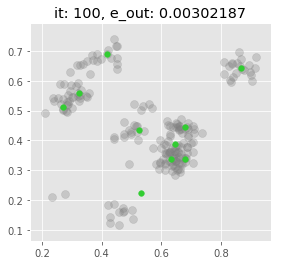

  [*] Overall it/s: 0.0193


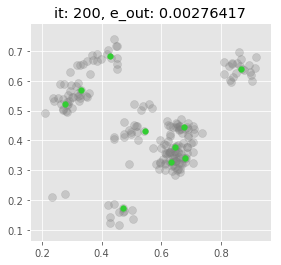

  [*] Overall it/s: 0.0177


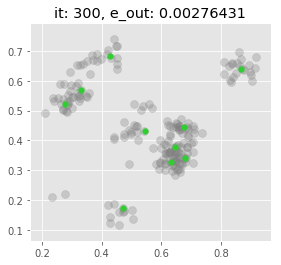

  [*] Time elapsed: 5.40


In [4]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, NUM_SUPP, MAX_ITER, LR, is_tf=IS_TF,
                                  power=ENERGY_POWER, y_init_option=Y_INIT_OPTION)  # NOTE: Power=2 to derive optimal SP.

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

In [ ]:
example_sigmas = [0.02, 0.04]
example_clusters = [5, 10, 30]
n_sig = len(example_sigmas)
n_clu = len(example_clusters)

fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
for i, sigma in enumerate(example_sigmas):
    for j, cluster_count in enumerate(example_clusters):
        temp_data = load_balog_data(NUM_DATA, DIM, cluster_count, sigma, make_new=True,
                                    do_weighted=False)
        temp_y_opt, temp_e_opt = get_support_points(temp_data, NUM_SUPP, MAX_ITER,
                                                    LR, is_tf=IS_TF, power=ENERGY_POWER,
                                                    plot=False)

        axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
        axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
        axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='limegreen', alpha=1)
        axs[i, j].set_xlim((0, 1))
        axs[i, j].set_ylim((0, 1))


plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('/Users/swilliamson/Work/Mo/pv/mv_sp_privacy/output/sp_optimization_various_clusterings.png')

___

## 4. Sample support points.

## 4.0 Sample support points with Exponential Mechanism, based on original data

Exp(2 * U / alpha) = Exp(2 * 0.0282 / 5000.00) = Exp(0.00001129)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0282 / 5000.000) = Exp(0.00001129)

Running chain. Length=105000, Burn=5000, Thin=2000
Difference factor: 88609.87

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00131454


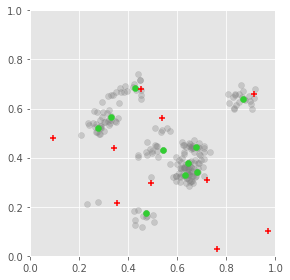

acceptance_rate=0.31596991, step_size=0.05043138
Energy diff: 0.00164607


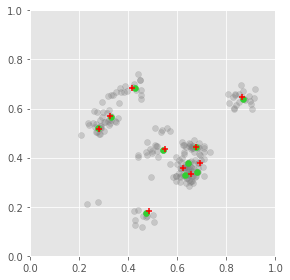

acceptance_rate=0.29474787, step_size=0.00230584
Energy diff: 0.00000786


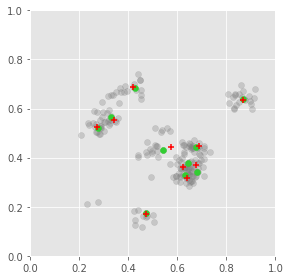

acceptance_rate=0.30224437, step_size=0.25000000
Energy diff: 0.00247589


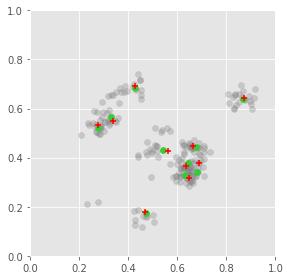

acceptance_rate=0.29592153, step_size=0.00450360
Energy diff: 0.00006814


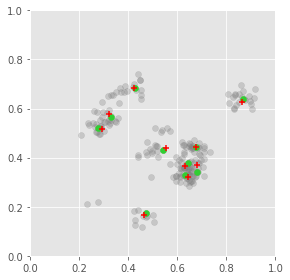

acceptance_rate=0.30302280, step_size=0.07207934
Energy diff: 0.00033301


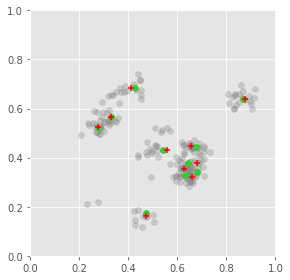

acceptance_rate=0.29755083, step_size=0.00703687
Energy diff: 0.00006183


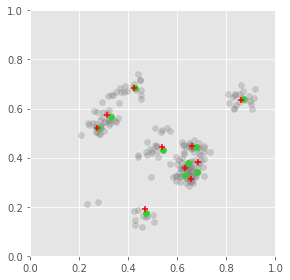

acceptance_rate=0.30022721, step_size=0.25000000
Energy diff: 0.00454535


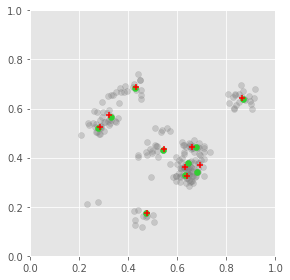

acceptance_rate=0.30169879, step_size=0.00188012
Energy diff: 0.00000651


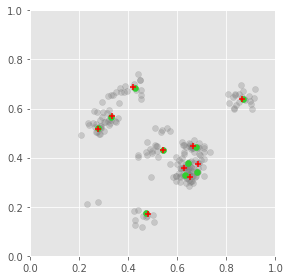

acceptance_rate=0.30144655, step_size=0.12455311
Energy diff: 0.00603129


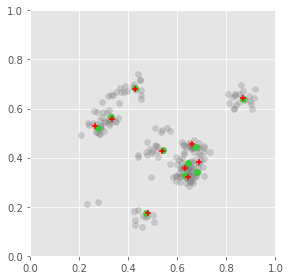

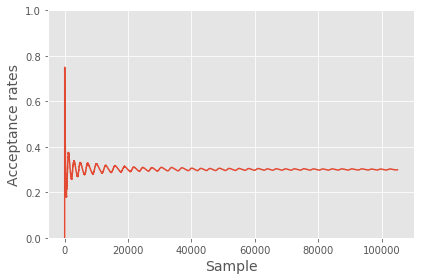

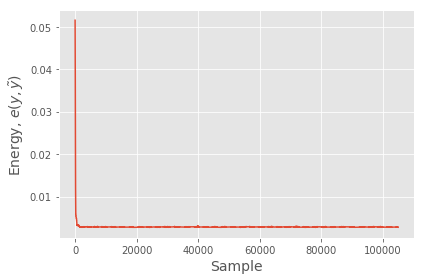

Acceptance rate: 0.299
percent steps that improved energy score: 0.151


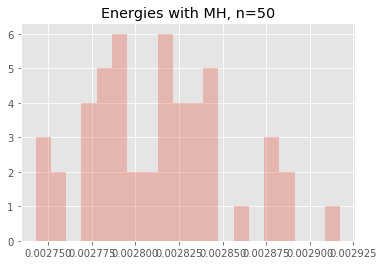

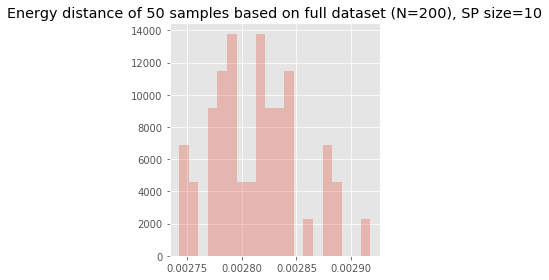

Exponential param: 0.00021496


In [9]:
# Sampling parameters.
NUM_Y_TILDES = 50 
ALPHA = 5000  # 10000
save_dir = '/Users/swilliamson/Work/Mo/pv/mv_sp_privacy/output'
# Define energy sensitivity for Exponential Mechanism.
N, D = x.shape
energy_sensitivity = get_energy_sensitivity(N, D, power=ENERGY_POWER)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.8f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

(y_tildes_full_data,
 energies_full_data,
 _) = sample_sp_exp_mech(energy_sensitivity=energy_sensitivity, 
                         data=x, 
                         num_support_points = NUM_SUPP, 
                         method='mh', 
                         num_y_tildes=NUM_Y_TILDES,
                         alpha=ALPHA, 
                         plot=1, 
                         save_dir=save_dir, 
                         power=ENERGY_POWER,
                         set_seed=True,
                         optimal_support_points=y_opt
                        )

# PLOT RESULTS
plt.title('Energy distance of {} samples based on full dataset (N={}), SP size={}'.format(NUM_Y_TILDES,
                                                                                         N,
                                                                                          NUM_SUPP
                                                                                         ))
plt.hist(energies_full_data, bins=20, alpha=0.3, density=True, label='Samples')


# Compare to Exponential density.
#p = exponential_param = 2. * energy_sensitivity / ALPHA
#xs = np.linspace(0, np.max(energies), 100)
#xs_dens = 1 / p * np.exp(-xs / p)
#plt.plot(xs, xs_dens, c='gray', label='Exponential density')
#plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'priv_sp_energies_full_data.png'))
plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()
print('Exponential param: {:.8f}'.format(p))

## 4.1 Sample support points with Exponential Mechanism, based on pre-selected support points


In [15]:
# Sampling parameters.
NUM_Y_TILDES = 50 #what is this?? Oh, number of samples
ALPHA = 5000  # 10000
save_dir = '/Users/swilliamson/Work/Mo/pv/mv_sp_privacy/output'
# Define energy sensitivity for Exponential Mechanism.
N, D = x.shape
energy_sensitivity = get_energy_sensitivity(NUM_SUPP, D, power=ENERGY_POWER)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.8f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

(y_tildes_pre_SP,
 energies_pre_SP,
 _) = sample_sp_exp_mech(energy_sensitivity=energy_sensitivity, 
                         data=y_opt, 
                         num_support_points = NUM_SUPP, 
                         method='mh', 
                         num_y_tildes=NUM_Y_TILDES,
                         alpha=ALPHA, 
                         plot=1, 
                         save_dir=save_dir, 
                         power=ENERGY_POWER,
                         set_seed=True,
                         optimal_support_points=y_opt,
                         original_data=
                        )

# PLOT RESULTS
#plt.title('Energies with MH, {} samples'.format(len(energies_mh)))

# above we have energies from the support points, for this we want energies from the data
total_energies_pre_SP = []
for y_t in y_tildes_pre_SP:
    total_energies_pre_SP.append(energy(y_t, x, power=ENERGY_POWER)[0])

plt.title('Energy distance of {} samples based on {} precalculated support points'.format(NUM_Y_TILDES,
                                                                                          NUM_SUPP
                                                                                         ))
plt.hist(total_energies_pre_SP, bins=20, alpha=0.3, density=True, label='Samples')

plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.tight_layout()
plt.savefig('../output/priv_sp_energies_preproc.png')
plt.show()
print('Exponential param: {:.8f}'.format(p))



# plot comparison with full data

plt.hist(energies_full_data, bins=20, alpha=0.3, density=True, color='r', label='Full data')
plt.hist(total_energies_pre_SP, bins=20, alpha=0.3, density=True, color='b', label='Support point preprocessing')
plt.legend()
plt.savefig('../output/priv_sp_energies_compare.png')
plt.show()

Exp(2 * U / alpha) = Exp(2 * 0.5374 / 5000.00) = Exp(0.00021496)


NameError: name 'data' is not defined

## Based on the above, we do better without intermediate calculation of support points

## 4.2 Sample w/ ExpMech on Data Directly (NUM_DATA=NUM_SUPP)

Exp(2 * U / alpha) = Exp(2 * 0.0282 / 5000.00) = Exp(0.00001129)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0282 / 5000.000) = Exp(0.00001129)

Running chain. Length=105000, Burn=5000, Thin=2000
Difference factor: 88609.87

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00004906


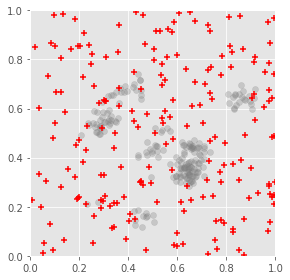

acceptance_rate=0.30235216, step_size=0.25000000
Energy diff: 0.00002073


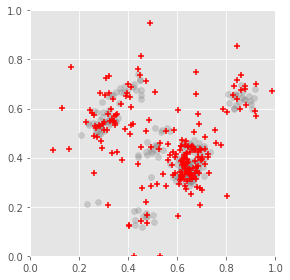

acceptance_rate=0.30055712, step_size=0.25000000
Energy diff: -0.00000463


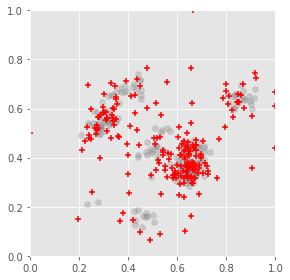

acceptance_rate=0.29980001, step_size=0.08192000
Energy diff: 0.00001835


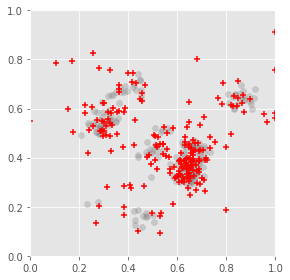

acceptance_rate=0.30030237, step_size=0.09830400
Energy diff: 0.00005721


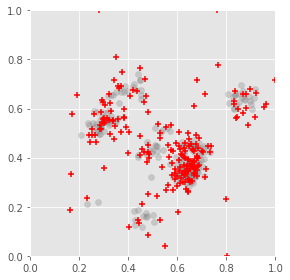

acceptance_rate=0.30054666, step_size=0.11324621
Energy diff: 0.00000227


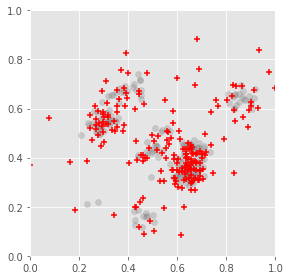

acceptance_rate=0.29990000, step_size=0.16000000
Energy diff: 0.00002991


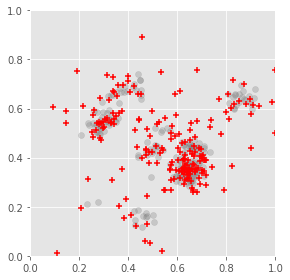

acceptance_rate=0.30017279, step_size=0.25000000
Energy diff: 0.00004635


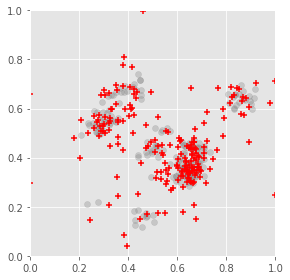

acceptance_rate=0.30010357, step_size=0.18432000
Energy diff: 0.00006305


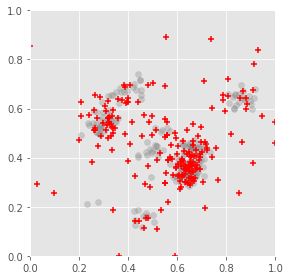

acceptance_rate=0.30035661, step_size=0.24461181
Energy diff: 0.00010961


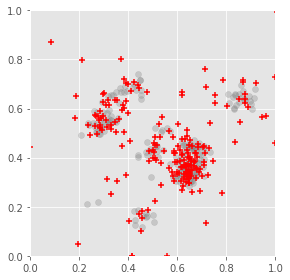

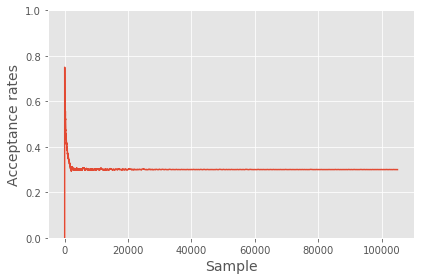

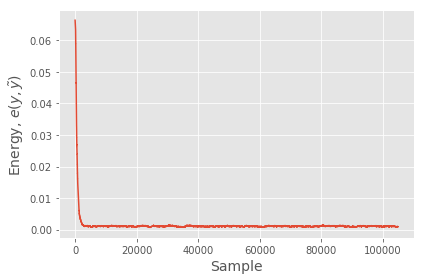

Acceptance rate: 0.300
percent steps that improved energy score: 0.152


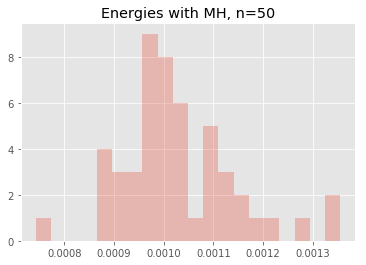

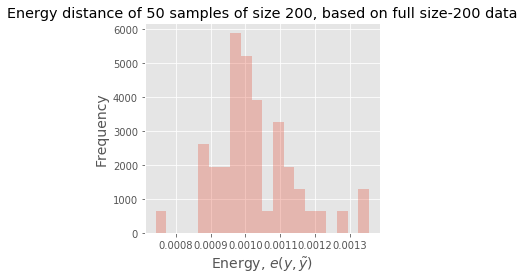

Exponential param: 0.00021496


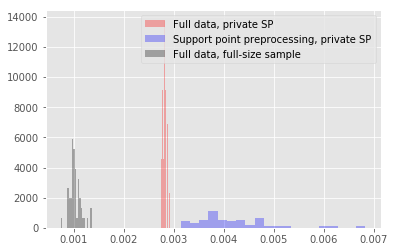

In [14]:

# Define energy sensitivity for Exponential Mechanism.
N, D = x.shape
energy_sensitivity = get_energy_sensitivity(N, D, power=ENERGY_POWER)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.8f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

(y_tildes_full_full,
 energies_full_full,
 _) = sample_sp_exp_mech(energy_sensitivity=energy_sensitivity, 
                         data=x, 
                         num_support_points = N, 
                         method='mh', 
                         num_y_tildes=NUM_Y_TILDES,
                         alpha=ALPHA, 
                         plot=1, 
                         save_dir=save_dir, 
                         power=ENERGY_POWER,
                         set_seed=True,
                         optimal_support_points=None
                        )

# PLOT RESULTS
#plt.title('Energies with MH, {} samples'.format(len(energies_mh)))

# above we have energies from the support points, for this we want energies from the data

plt.title('Energy distance of {} samples of size {}, based on full size-{} data'.format(NUM_Y_TILDES,
                                                                                        N, N))
plt.hist(energies_full_full, bins=20, alpha=0.3, density=True, label='Samples')

plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.tight_layout()
plt.savefig('../output/priv_sp_energies_preproc.png')
plt.show()
print('Exponential param: {:.8f}'.format(p))



# plot comparison with full data

plt.hist(energies_full_data, bins=20, alpha=0.3, density=True, color='r', label='Full data, private SP')
plt.hist(total_energies_pre_SP, bins=20, alpha=0.3, density=True, color='b', label='Support point preprocessing, private SP')
plt.hist(energies_full_full, bins=20, alpha=0.3, density=True, color='k', label='Full data, full-size sample')
plt.legend()
plt.savefig('../output/priv_sp_energies_compare_all.png')
plt.show()

## Full data -> Full size synthesis unsurprisingly best, then Full data -> Private SP, then Full data -> Non-private SP -> Private SP

In [ ]:
"""
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()
"""

#### Paper: Figure of private support point samples with various alphas.

In [ ]:
example_alphas = [1, 100, 500, 1000, 5000]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


for i, alpha in enumerate(example_alphas):
    (y_tildes,
     energies,
     energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                         x, y_opt, 'mh',
                                         num_y_tildes=1,
                                         alpha=alpha,
                                         plot=False,
                                         power=ENERGY_POWER,
                                         set_seed=True)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tildes[0, :, 0],
                   y_tildes[0, :, 1],
                   c='red', alpha=1,
                   marker='+')
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/sp_various_alphas.png')
plt.show()

___

## 5. Expand to full data set.

## 5.0 KDE with pre-selected bandwidth.

#### Given privately sampled SP, expand them using KDE and pre-selected bandwidth.

In [ ]:
ALPHA = 1000

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=ENERGY_POWER)  # Note: Num supp = len(x).

print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))


FULL_SAMPLE_SIZE = NUM_DATA
PLOT = 1

In [ ]:
# Show data and y_tilde.
bandwidths = [SIGMA_DATA * 4, SIGMA_DATA, SIGMA_DATA / 4]
n_bw = len(bandwidths)

fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(bandwidths):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt,
                                                          ALPHA, bw,
                                                          FULL_SAMPLE_SIZE, 
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=True)

    axs[i].set_title(r'$\sigma$={:.3f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, marker='+')
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/kde_fixed_bandwidth.png')

## 5.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.

In [ ]:
ALPHA = 500

In [ ]:
ys, es, _ = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                               'mh', num_y_tildes=1, alpha=ALPHA,
                               power=ENERGY_POWER, set_seed=False)
y_tilde = ys[0]

# Sample from mixture model centered on noisy support points.
choices = np.random.choice(range(len(y_tilde)), size=NUM_DATA)
y_tilde_upsampled = y_tilde[choices]


# Find optimal bandwidth using Maximum Likelihood.
BW_LOW = 0.0001
BW_HIGH = 0.05
NUM_BANDWIDTHS = 20
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE): 
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]

In [ ]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, $\sigma$={:.5f}, $\hat{{\sigma}}$={:.5f}, {}={:.3e}'.format(
    SIGMA_DATA, bw_best, lik_str, bw_best_lik))
plt.legend()
plt.savefig('../output/mle_bw_range.png')
plt.show()

#### Show samples with best and worst bandwidth.

In [ ]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='Y_OPT, best bw: ',
                                        plot=True)
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='Y_TILDE, best bw: ',
                                          plot=True)
print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample_best = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if 1:
    # Plot with only data and support points.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    #plt.title((r'Best full sample. $\sigma$={:.5f}, '
    #           '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
    #                                                         bw_best,
    #                                                         bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_pre_kde.png')
    plt.show()
    
    # Plot with best bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_best[:, 0], new_sample_best[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title((r'Best full sample. $\sigma$={:.5f}, '
               '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(
        SIGMA_DATA, bw_best, bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_best_bw.png')
    plt.show()

    # Plot with worst bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title((r'Worst full sample. $\sigma$={:.5f}, '
                '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                              bw_worst,
                                                              bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.

In [ ]:
dp_bandwidths = []
floor = 1e-3
n_bw = 4

for _ in range(n_bw):
    dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
    dp_bandwidth = np.max([dp_bandwidth_raw, floor])
    dp_bandwidths.append(dp_bandwidth)
    print('\nBest bw: {:>14.6f}\nraw DP bw: {:>12.6f}\nCorrected DP bw: {:>1.6f}'.format(
            bw_best, dp_bandwidth_raw, dp_bandwidth))



fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(dp_bandwidths):
    y_tilde_expansion = (
        y_tilde_upsampled +
        np.random.normal(0, bw, size=(FULL_SAMPLE_SIZE, x.shape[1])))


    axs[i].set_title(r'$\sigma$={:.6f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/mle_bw_dp.png')

## 5.3 Repeated draws of private support points.

#### Once with lower budget to show disperse output.

In [ ]:
ALPHA = 1000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_dispersed.png')
plt.show()

#### Once with higher budget to show focused output.

In [ ]:
ALPHA = 5000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_focused.png')
plt.show()

# End.